# How to Find & Match Faces in an Image
---

So here is a sample notebook where you can find all the faces in an image, crop the face, then match to a database(collection) of faces. 

follow the notebook step by step, then modify for your own code. 
you'll need to change 
- bucket name
- collection name 



In [1]:
# AWS SDK for Python
import boto3
from botocore.exceptions import ClientError

# Image processing
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageEnhance

# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Standard Python libraries for web requests and file handling
import requests
import zipfile
import os
import re
import io

# Display utilities
from IPython.display import display


# Detect & Match all Faces in an Image

## Setup
0. download images headshots and attendance 
    - unzip images, make note of local direcrories! 
1. create a bucket of headshots & attendance
    - upload all the images 
2. create a collection (a database to search) headshots
3. index headshots into the collection (now it's searchable) 

## Create Supporting Functions 

## Loop over Faces 

## Present 

In [2]:
# download headshots 
!gdown --id 1ykXmEXCwqVGZTzTk73W-nmlWdK4o3qDy

/opt/anaconda3/lib/python3.9/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ykXmEXCwqVGZTzTk73W-nmlWdK4o3qDy
From (redirected): https://drive.google.com/uc?id=1ykXmEXCwqVGZTzTk73W-nmlWdK4o3qDy&confirm=t&uuid=b7ff8e07-3076-4c96-bc3e-d5066e677338
To: /Users/helenas/Desktop/Data Management/Project/Final Project/2022 MSBA Headshot Photos.zip
100%|████████████████████████████████████████| 283M/283M [00:07<00:00, 39.9MB/s]


In [3]:
# download attendance records 
!gdown --id 1qMK4Hf4qsbXkSftCrjVINzE-ebblm9AO

/opt/anaconda3/lib/python3.9/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qMK4Hf4qsbXkSftCrjVINzE-ebblm9AO
To: /Users/helenas/Desktop/Data Management/Project/Final Project/ExampleAttendance.zip
100%|██████████████████████████████████████| 3.11M/3.11M [00:00<00:00, 8.39MB/s]


In [4]:
# List all the headshots files in the unzipped folder
headshots_list = os.listdir('/Users/helenas/Desktop/Data Management/Project/Final Project/2024 MSBA Headshot Photos')

# Print the list of files
print(f"number of headshots: {len(headshots_list)}")

number of headshots: 125


In [9]:
headshots_list

['Bingyu_Li.jpg',
 'Whitney_Joyce_Isbell.jpg',
 'Qian_Chen.jpg',
 'Hanshuai_Shi.jpg',
 'Ruochen_Bao.jpg',
 'Joseph_Miller_Hirsch.jpg',
 'Mary_Martha_Milcoff.jpg',
 'Anthony_X_Ayala.jpg',
 'Millie_C_Garrett.jpg',
 'Mengyao_Liu.jpg',
 'Dongqiao_Tang.jpg',
 'Boyan_Wei.jpg',
 'Latham_Alexander_Weaver.jpg',
 'Nicholas_J_Sundberg.jpg',
 'Andrew_Lloyd_Loftis.jpg',
 'Zihe_Liu.jpg',
 'Shuzhe_Wang.jpg',
 'Jiahua_Wu.jpg',
 'Patrick_Ryan_Weimaker.jpg',
 'Max_Koontz.jpg',
 'Tianyi_Yin.jpg',
 'Hewei_Shen.jpg',
 'Andrea_Chen.jpg',
 'Anne_M_Perry.jpg',
 'Benjamin_Pyung-Hwa_Aikens.jpg',
 'Meghan_O_Malley.jpg',
 'Edward_Cheongjoun_Hyun.jpg',
 'Joseph_Macon_Barker.jpg',
 'Jodie_Elizabeth_Brine.jpg',
 'Evan_Anderson_Gilbert.jpg',
 'Lauren_Elizabeth_Johnson.jpg',
 'Kendall_Ashley_Hilson.jpg',
 'Nicolson_Charles_Panos.jpg',
 'Tianyi_Chen.jpg',
 'Amanda_Renner_Gild.jpg',
 'Kyle_John_Wiblishauser.jpg',
 'Allen_Gail_Smith.jpg',
 'Haopeng_Liu.jpg',
 'Yiming_Xu.jpg',
 'Niklas_Jozef_Baldis.jpg',
 'Jeremy_Brian_Nu

## Create Bucket & Collections
---

In [5]:
# create bucket 
s3 = boto3.client('s3')
s3_bucket = 'shenh-attendance-2024' # change to your bucket 

try:
    s3.create_bucket(Bucket=s3_bucket)
    print(f"Bucket '{s3_bucket}' created successfully.")
except ClientError as error:
    error_code = error.response['Error']['Code']
    if error_code == 'BucketAlreadyOwnedByYou':
        print(f"Bucket '{s3_bucket}' already exists and is owned by you.")
    elif error_code == 'BucketAlreadyExists':
        print(f"Bucket '{s3_bucket}' already exists and is owned by someone else.")
    else:
        print(f"An error occurred: {error.response['Error']['Message']}")


Bucket 'shenh-attendance-2024' created successfully.


In [6]:
# create collection 
client = boto3.client('rekognition')
collection_id = 'shenh-headshot-collection'

try:
    client.create_collection(CollectionId=collection_id)
except ClientError as error:
    error_code = error.response['Error']['Code']
    if error_code == 'ResourceAlreadyExistsException':
        print('Collection already exists.')
    else:
        print(f'An error occurred: {error.response["Error"]["Message"]}')

import boto3
from botocore.exceptions import ClientError

client = boto3.client('rekognition')
#collection_id = 'your-collection-id'  # Replace with your collection ID

# Delete the collection
try:
    delete_response = client.delete_collection(CollectionId=collection_id)
    print(f"Collection '{collection_id}' deleted. Status Code: {delete_response['StatusCode']}")
except ClientError as error:
    print(f"Error occurred while deleting collection: {error.response['Error']['Message']}")

# Recreate the collection
try:
    create_response = client.create_collection(CollectionId=collection_id)
    print(f"Collection '{collection_id}' created. Status Code: {create_response['StatusCode']}")
except ClientError as error:
    print(f"Error occurred while creating collection: {error.response['Error']['Message']}")


Collection 'shenh-headshot-collection' deleted. Status Code: 200
Collection 'shenh-headshot-collection' created. Status Code: 200


## Upload Images to Bucket

In [11]:
# upload headshots to bucket 
wd = os.getcwd()
for file in headshots_list:
    file_path = f"/Users/helenas/Desktop/Data Management/Project/Final Project/2024 MSBA Headshot Photos/{file}"
    s3.upload_file(file_path, s3_bucket, file)
    
print(f"uploaded {len(headshots_list)} headshots")

uploaded 125 headshots


In [12]:
# upload attedance images 
attendance_list = ['IMG_1935.jpg', 'IMG_1936.jpg','IMG_1937.jpg']
for file in attendance_list:
    file_path = f"/Users/helenas/Desktop/Data Management/Project/Final Project/2024_attendance/{file}"
    s3.upload_file(file_path, s3_bucket, file)

print(f"uploaded {len(attendance_list)} headshots")  

uploaded 3 headshots


## Index Headshots into Collection
---

> note: the number one problem is the ExternalImageID name it can only contain these characters: [^a-zA-Z0-9_:] if you don't deal with the image names likely you'll encounter an error


In [13]:
# index all the headshots 
for image in headshots_list:
    # print(image)
    # make sure the names adhear to requirements 
    externalImageId = (image
                      .replace(" ", "_")
                      .replace(",","_")
                      .replace("(","")
                      .replace(")","")
                      .replace(".jpg","")
                      .replace("_1","")
                      .replace("_2","")
                     )
    # make a name that you can use! 
    externalImageId = re.sub(r'[^a-zA-Z0-9_:]', '', externalImageId)
    
    # index the faces 
    client.index_faces(CollectionId=collection_id,
                                               Image={'S3Object': {'Bucket': s3_bucket, 'Name': image}},
                                               ExternalImageId=externalImageId, # this is the name of the person!!! 
                                               MaxFaces=1,
                                               QualityFilter="AUTO",
                                               DetectionAttributes=['ALL'])
    print(f" indexed: {externalImageId}")

 indexed: Bingyu_Li
 indexed: Whitney_Joyce_Isbell
 indexed: Qian_Chen
 indexed: Hanshuai_Shi
 indexed: Ruochen_Bao
 indexed: Joseph_Miller_Hirsch
 indexed: Mary_Martha_Milcoff
 indexed: Anthony_X_Ayala
 indexed: Millie_C_Garrett
 indexed: Mengyao_Liu
 indexed: Dongqiao_Tang
 indexed: Boyan_Wei
 indexed: Latham_Alexander_Weaver
 indexed: Nicholas_J_Sundberg
 indexed: Andrew_Lloyd_Loftis
 indexed: Zihe_Liu
 indexed: Shuzhe_Wang
 indexed: Jiahua_Wu
 indexed: Patrick_Ryan_Weimaker
 indexed: Max_Koontz
 indexed: Tianyi_Yin
 indexed: Hewei_Shen
 indexed: Andrea_Chen
 indexed: Anne_M_Perry
 indexed: Benjamin_PyungHwa_Aikens
 indexed: Meghan_O_Malley
 indexed: Edward_Cheongjoun_Hyun
 indexed: Joseph_Macon_Barker
 indexed: Jodie_Elizabeth_Brine
 indexed: Evan_Anderson_Gilbert
 indexed: Lauren_Elizabeth_Johnson
 indexed: Kendall_Ashley_Hilson
 indexed: Nicolson_Charles_Panos
 indexed: Tianyi_Chen
 indexed: Amanda_Renner_Gild
 indexed: Kyle_John_Wiblishauser
 indexed: Allen_Gail_Smith
 indexed: 

1. detect faces in an image
2. for each face, 
    crop the face, 
    look up the face in the collection
        if found then 
        else 
3. show image and table of folks found. 


## Bunch of Functions 
---

- download_image_from_s3 - downloads an image to local directory 
- crop_image - extracts a face from an image 
- detect_faces - find all the faces in attendance image 
- search_face_by_image - for each face search to see if it's in the collection
- draw_bounding_box_with_label - on the attendance image draw bounding boxes around faces found. 

In [14]:
import boto3
import io
from PIL import Image, ImageDraw, ImageFont


def download_image_from_s3(bucket, image_key):
    s3_client = boto3.client('s3')
    s3_response = s3_client.get_object(Bucket=bucket, Key=image_key)
    image_content = s3_response['Body'].read()

    return Image.open(io.BytesIO(image_content))


def crop_image(bucket, image_key, box):
    img = download_image_from_s3(bucket, image_key)
    cropped_img = img.crop(box)
    in_mem_file = io.BytesIO()
    cropped_img.save(in_mem_file, format='JPEG')  # Specify format as needed
    in_mem_file.seek(0)
    return in_mem_file


def detect_faces(bucket, image_key):
    client = boto3.client('rekognition')
    response = client.detect_faces(
        Image={'S3Object': {'Bucket': bucket, 'Name': image_key}},
        Attributes=['DEFAULT']
    )
    return response['FaceDetails']


def search_face_by_image(collection_id, bucket, image_key, box):
    client = boto3.client('rekognition')
    # crop the image 
    cropped_image = crop_image(bucket, image_key, box)
    try:
        response = client.search_faces_by_image(CollectionId=collection_id, 
                                                Image={'Bytes': cropped_image.read()})
        MatchedFaces = response['FaceMatches']
    except:
        MatchedFaces = []
    return MatchedFaces


def draw_bounding_box_with_label(image, box, matches):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    if matches:  # Check if the list of matches is not empty
        for match in matches:
            external_id = match['Face']['ExternalImageId']
            similarity = match['Similarity']

            draw.rectangle(box, outline='lightgreen', width=3)
            label = f"ID: {external_id}Sim: {similarity:.2f}%"
            draw.text((box[0], box[3] + 10), label, fill="white", font=font)
    else:
        # Optional: Draw a box and label indicating no match
        draw.rectangle(box, outline='red', width=3)
        draw.text((box[0], box[3] + 10), "No Match", fill="white", font=font)

    return image


def draw_bounding_box_with_label(image, box, match):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    # Access 'ExternalImageId' and 'Similarity' correctly from the nested 'Face' dictionary
    external_id = match['Face'].get('ExternalImageId', 'Unknown')  # Use .get for safer access
    similarity = match.get('Similarity', 0)  # Default to 0 if key is missing

    draw.rectangle(box, outline='lightgreen', width=4)
    label = f"ID: {external_id} ({similarity:.2f}%)"
    draw.text((box[0], box[3] + 10), label, fill="white", font=font)  # Adjust text position if necessary

    return image


## Driver program. 

for each face found in attendance image 
- search the index 
    - if matched: 
        - green bounding box w. externalID and similarity %
    - else:
        - red boudning box w. No-Matched Label
        
- make a list of all matches, put into a dataframe 

In [16]:
# Main Code
bucket_name = 'shenh-attendance-2024'
image_key = 'IMG_1935.jpg' # attendance image 
collection_id = 'shenh-headshot-collection'

# Download the image once
img = download_image_from_s3(bucket_name, image_key)
image_width, image_height = img.size

# detect all faces in attendance 
faces = detect_faces(bucket_name, image_key)

# empty list to store matches 
match_list = []
match_count = 0
nomatch_count = 0

# -- MAIN LOOP --
for face in faces:
    box = face['BoundingBox']
    box_coordinates = (
        int(box['Left'] * image_width),
        int(box['Top'] * image_height),
        int(box['Left'] * image_width + box['Width'] * image_width),
        int(box['Top'] * image_height + box['Height'] * image_height)
    )

    matches = search_face_by_image(collection_id, bucket_name, image_key, box_coordinates)
    #print("Matches for face:", matches)

    # Check if there are matches and draw bounding box
    if matches:
        for match in matches:
            img = draw_bounding_box_with_label(img, box_coordinates, match)
            match_list.append(match)
            match_count = match_count + 1
    else:
        # Optional: Draw a box indicating no match
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        draw.rectangle(box_coordinates, outline='red', width=3)
        draw.text((box_coordinates[0], box_coordinates[3] + 10), "No Match", fill="white", font=font)
        nomatch_count = nomatch_count + 1
# Display or save the image as needed
img.show()
img.save(f'{image_key}_annotated_image.jpg')
print(f"** Matched {match_count} face count")
print(f"** No-match {nomatch_count} face count")

** Matched 12 face count
** No-match 1 face count


In [17]:
import pandas as pd

# Flatten the nested dictionaries
flattened_data = []
for entry in match_list:
    flattened_entry = {}
    flattened_entry.update(entry)
    flattened_entry.update(entry['Face'])
    flattened_entry.update(entry['Face']['BoundingBox'])
    del flattened_entry['Face']
    flattened_entry['BoundingBox'] = str(flattened_entry['BoundingBox'])  # If you want to keep the BoundingBox as a string representation
    flattened_data.append(flattened_entry)

# Create the DataFrame
df = pd.DataFrame(flattened_data)

df


,Similarity,FaceId,BoundingBox,ImageId,ExternalImageId,Confidence,IndexFacesModelVersion,Width,Height,Left,Top
0,99.926697,373d6316-1684-4465-b35e-f7245269b81e,"{'Width': 0.13905100524425507, 'Height': 0.263...",1de63a54-8d1e-306b-8ab7-1ec57e4b4f12,Jeremy_Brian_Nurding,99.999603,7.0,0.139051,0.263965,0.424585,0.352247
1,80.336067,9ae11e7c-0940-438e-bb2f-98ad0145a3fd,"{'Width': 0.14328999817371368, 'Height': 0.266...",2a9ffda4-e144-37ab-a730-c25c520efae4,Hewei_Shen,99.999901,7.0,0.143290,0.266417,0.451409,0.261148
2,99.997070,68146ca9-b6c3-4d17-90c5-1e0435ec28f8,"{'Width': 0.14963899552822113, 'Height': 0.300...",1c53da1b-7d6d-3f2a-87a6-914f2e170a1b,Joseph_Macon_Barker,99.999794,7.0,0.149639,0.300006,0.437293,0.227108
3,99.826584,af89d230-d6af-45c1-a9b8-5c2132bcab49,"{'Width': 0.1344040036201477, 'Height': 0.2419...",c40f1cbd-5ac5-3709-a53a-d6d5df3818c2,Mengyao_Liu,99.999702,7.0,0.134404,0.241907,0.442374,0.247034
4,99.994095,a2a7771f-aef9-4827-a653-f78619145379,"{'Width': 0.1618250012397766, 'Height': 0.3107...",46affd33-17e1-3648-b77c-daee501d5841,Logan_Trujillo,99.999901,7.0,0.161825,0.310743,0.413054,0.240411
5,99.877563,42848d6e-0a1e-4466-a0d6-3026469e35b7,"{'Width': 0.12602700293064117, 'Height': 0.219...",43654767-0079-3264-84ae-7f66c405d104,Anne_M_Perry,99.999603,7.0,0.126027,0.219239,0.443087,0.253212
6,99.806854,e0d823e7-2630-418f-af44-3b29668e10df,"{'Width': 0.13361099362373352, 'Height': 0.251...",83f5e91d-a93f-39fd-951e-a82436e2a272,Marcus_Cole_cooper,99.999603,7.0,0.133611,0.251992,0.432392,0.259969
7,87.224953,7a563579-5fc0-45f8-8caf-0fdf77265110,"{'Width': 0.15109199285507202, 'Height': 0.272...",a2ac45fe-96fd-34dc-b989-0c2744490eaf,Zaul_Alexander_Perez,99.999794,7.0,0.151092,0.272164,0.440914,0.256196
8,99.406097,7b5bd012-12b1-448f-bcac-f6e926275848,"{'Width': 0.15636900067329407, 'Height': 0.287...",da35e607-d9b4-3872-abf7-8e80dab5191e,Cheuk_Yui_Marcus_Chan,99.999901,7.0,0.156369,0.287876,0.463145,0.221010
9,98.933701,45eaf437-08e0-470e-8ad2-b1380fea6c6b,"{'Width': 0.13007499277591705, 'Height': 0.251...",1a0afb7a-9eab-32d2-9d6a-4102d8b0d269,Raleigh_Coolidge_Conway,99.999496,7.0,0.130075,0.251483,0.434009,0.221396


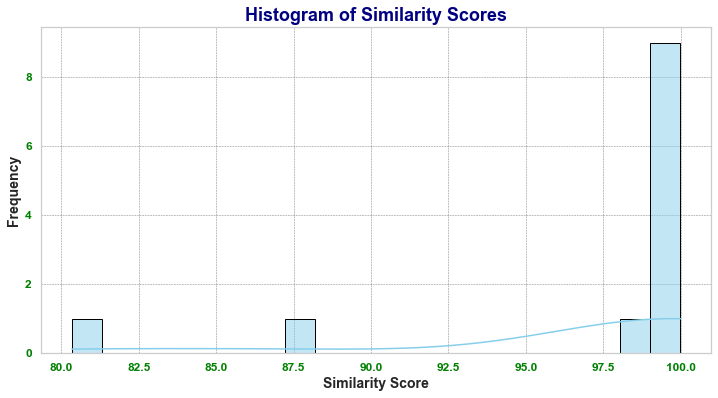

In [21]:
# Set the style and color palette of the plot
sns.set(style="whitegrid", palette="pastel")

# Set the figure size 
plt.figure(figsize=(12, 6))  # Width, Height in inches

# Create the histogram
sns.histplot(data=df, x='Similarity', bins=20, kde=True, color='skyblue', edgecolor='black')

# Add a title and labels
plt.title("Histogram of Similarity Scores", fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Similarity Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Customize the ticks
plt.xticks(fontsize=12, fontweight='bold', color='green')
plt.yticks(fontsize=12, fontweight='bold', color='green')

# Add a grid for easier reading
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()



In [22]:
# Main Code
bucket_name = 'shenh-attendance-2024'
image_key = 'IMG_1936.jpg' # attendance image 
collection_id = 'shenh-headshot-collection'

# Download the image once
img = download_image_from_s3(bucket_name, image_key)
image_width, image_height = img.size

# detect all faces in attendance 
faces = detect_faces(bucket_name, image_key)

# empty list to store matches 
match_list = []
match_count = 0
nomatch_count = 0

# -- MAIN LOOP --
for face in faces:
    box = face['BoundingBox']
    box_coordinates = (
        int(box['Left'] * image_width),
        int(box['Top'] * image_height),
        int(box['Left'] * image_width + box['Width'] * image_width),
        int(box['Top'] * image_height + box['Height'] * image_height)
    )

    matches = search_face_by_image(collection_id, bucket_name, image_key, box_coordinates)
    #print("Matches for face:", matches)

    # Check if there are matches and draw bounding box
    if matches:
        for match in matches:
            img = draw_bounding_box_with_label(img, box_coordinates, match)
            match_list.append(match)
            match_count = match_count + 1
    else:
        # Optional: Draw a box indicating no match
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        draw.rectangle(box_coordinates, outline='red', width=3)
        draw.text((box_coordinates[0], box_coordinates[3] + 10), "No Match", fill="white", font=font)
        nomatch_count = nomatch_count + 1
# Display or save the image as needed
img.show()
img.save(f'{image_key}_annotated_image.jpg')
print(f"** Matched {match_count} face count")
print(f"** No-match {nomatch_count} face count")

** Matched 12 face count
** No-match 1 face count


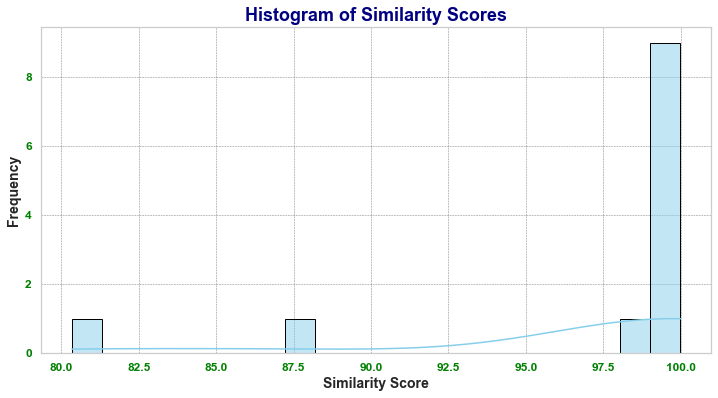

In [23]:
# Set the style and color palette of the plot
sns.set(style="whitegrid", palette="pastel")

# Set the figure size 
plt.figure(figsize=(12, 6))  # Width, Height in inches

# Create the histogram
sns.histplot(data=df, x='Similarity', bins=20, kde=True, color='skyblue', edgecolor='black')

# Add a title and labels
plt.title("Histogram of Similarity Scores", fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Similarity Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Customize the ticks
plt.xticks(fontsize=12, fontweight='bold', color='green')
plt.yticks(fontsize=12, fontweight='bold', color='green')

# Add a grid for easier reading
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()



In [24]:
# Main Code
bucket_name = 'shenh-attendance-2024'
image_key = 'IMG_1937.jpg' # attendance image 
collection_id = 'shenh-headshot-collection'

# Download the image once
img = download_image_from_s3(bucket_name, image_key)
image_width, image_height = img.size

# detect all faces in attendance 
faces = detect_faces(bucket_name, image_key)

# empty list to store matches 
match_list = []
match_count = 0
nomatch_count = 0

# -- MAIN LOOP --
for face in faces:
    box = face['BoundingBox']
    box_coordinates = (
        int(box['Left'] * image_width),
        int(box['Top'] * image_height),
        int(box['Left'] * image_width + box['Width'] * image_width),
        int(box['Top'] * image_height + box['Height'] * image_height)
    )

    matches = search_face_by_image(collection_id, bucket_name, image_key, box_coordinates)
    #print("Matches for face:", matches)

    # Check if there are matches and draw bounding box
    if matches:
        for match in matches:
            img = draw_bounding_box_with_label(img, box_coordinates, match)
            match_list.append(match)
            match_count = match_count + 1
    else:
        # Optional: Draw a box indicating no match
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        draw.rectangle(box_coordinates, outline='red', width=3)
        draw.text((box_coordinates[0], box_coordinates[3] + 10), "No Match", fill="white", font=font)
        nomatch_count = nomatch_count + 1
# Display or save the image as needed
img.show()
img.save(f'{image_key}_annotated_image.jpg')
print(f"** Matched {match_count} face count")
print(f"** No-match {nomatch_count} face count")

** Matched 10 face count
** No-match 1 face count


In [ ]:
** Matched 12 face count
** No-match 1 face count

** Matched 12 face count
** No-match 1 face count

** Matched 10 face count
** No-match 1 face count

In [ ]:
Number of faces detected: 11
Closest match: Logan_Trujillo(62%)
Closest match: Jeremy_Brian_Nurding(49%)
Closest match: Patrick_Ryan_Weimaker(57%)
Closest match: Raleigh_Coolidge_Conway(50%)
Closest match: Cheuk_Yui_Marcus_Chan(54%)
Closest match: Mengyao_Liu(56%)
Closest match: Joseph_Macon_Barker(65%)
Closest match: Zaul_Alexander_Perez(52%)
Closest match: Jash_Sanjaybhai_Vachhani(53%)
Closest match: Anne_M_Perry(53%)
Closest match: Marcus_Cole_cooper(47%)

Number of faces detected: 11
Closest match: Jennifer_Ontiveros-Olivas(52%)
Closest match: Christopher_David_Koontz(56%)
Closest match: Quinn_Poole(65%)
Closest match: Boyu_Zheng(61%)
Closest match: Dongqiao_Tang(67%)
Closest match: Bryce_Charles_Drynan(44%)
Closest match: John_William_Null(57%)
Closest match: Marcus_Cole_cooper(46%)
Closest match: Cole_Ritchey(40%)
Closest match: Tianyi_Chen(44%)
Closest match: Anthony_X_Ayala(41%)

Number of faces detected: 9
Closest match: Yilin_Wang(73%)
Closest match: Siyu_Lin(66%)
Closest match: Latham_Alexander_Weaver(56%)
Closest match: Chengzhan_Shen(58%)
Closest match: Millie_C_Garrett(58%)
Closest match: Jiahao_Ma(50%)
Closest match: Christopher_David_Koontz(53%)
Closest match: Dillon_Hunter_Aryeh(47%)
Closest match: Natalie_Weiner(57%)